In [2]:
# import dependency yang diperlukan
import tensorflow as tf
import os
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [3]:
Base_data = 'data' #mengambil direktori tempat dataset dan menyimpan ke variabel Base_data

In [4]:
# Preprocessing 
import cv2
import os
import imghdr
data = tf.keras.utils.image_dataset_from_directory(Base_data, image_size=(224,224))
data_dir = Base_data 
image_exts = ['png','jpeg']
image_size = (224, 224)

for image_class in os.listdir(data_dir): 
    for image_name in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image_name)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)

            if tip not in image_exts or 'mask' in image_name: 
                # menghapus gambar yang terdapat 'mask' pada nama file
                os.remove(image_path)
            else:
                img = cv2.resize(img, image_size)
                cv2.imwrite(image_path, img)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))

Found 449 files belonging to 2 classes.


In [5]:
# Menampilkan nama kelas dan jumlah gambar dari setiap kelas
number_of_images = {}
for dir in os.listdir(Base_data):
  number_of_images[dir] = len(os.listdir(os.path.join(Base_data, dir)))

number_of_images.items()

dict_items([('benign', 239), ('malignant', 210)])

In [6]:
# mendefinisikan kelas pada dataset
unique_classes = []
for path in os.listdir(Base_data):
    unique_classes.append(path)
print(unique_classes)
class_index = [unique_classes[1], unique_classes[0]]
label_encoder = LabelEncoder()

# mengubah class_index
encoded_classes = label_encoder.fit_transform(class_index)

# menampilkan kelas yang didefinisikan dan nilai dari index nya
for c, e in zip(class_index, encoded_classes):
    print(c, "-", e)

['benign', 'malignant']
malignant - 1
benign - 0


In [7]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

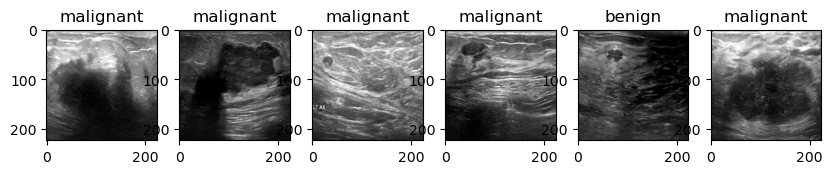

In [8]:
# Menampilkan beberapa gambar pada dataset beserta labelnya
fig, ax = plt.subplots(ncols=6, figsize=(10,10))
for idx, img in enumerate(batch[0][:6]):
    ax[idx].imshow(img.astype(int))
    if batch[1][idx] == 0:
        ax[idx].title.set_text('benign')
    else:
        ax[idx].title.set_text('malignant')

In [9]:
# Scale data
data = data.map(lambda x,y: (x/255, y))
data.as_numpy_iterator().next()

(array([[[[0.00784314, 0.00784314, 0.00784314],
          [0.03137255, 0.03137255, 0.03137255],
          [0.78431374, 0.78431374, 0.78431374],
          ...,
          [0.83137256, 0.83137256, 0.83137256],
          [0.8392157 , 0.8392157 , 0.8392157 ],
          [0.8039216 , 0.8039216 , 0.8039216 ]],
 
         [[0.7921569 , 0.7921569 , 0.7921569 ],
          [0.67058825, 0.67058825, 0.67058825],
          [0.7921569 , 0.7921569 , 0.7921569 ],
          ...,
          [0.8156863 , 0.8156863 , 0.8156863 ],
          [0.84313726, 0.84313726, 0.84313726],
          [0.827451  , 0.827451  , 0.827451  ]],
 
         [[0.10588235, 0.10588235, 0.10588235],
          [0.65882355, 0.65882355, 0.65882355],
          [0.79607844, 0.79607844, 0.79607844],
          ...,
          [0.7607843 , 0.7607843 , 0.7607843 ],
          [0.7882353 , 0.7882353 , 0.7882353 ],
          [0.77254903, 0.77254903, 0.77254903]],
 
         ...,
 
         [[0.27450982, 0.27450982, 0.27450982],
          [0.24705

In [10]:
len(data) #melihat banyaknya batch data yang akan diproses

15

In [11]:
# Split data 
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)


In [12]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [13]:
len(test) #melihat banyaknya batch data untuk testing

1

In [14]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [15]:
model = Sequential()

# Conv layer 1
model.add(Conv2D(32, (3,3), 1, activation='relu', padding='same', input_shape=(224,224,3)))
model.add(MaxPooling2D())

# Conv layer 2
model.add(Conv2D(64, (3,3), 1, activation='relu', padding='same'))
model.add(MaxPooling2D())

# Conv layer 3
model.add(Conv2D(32, (3,3), 1, activation='relu', padding='same'))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(224, activation='relu'))
# Drop rate untuk mengurangi overfitting
model.add(Dropout(0.2)) 
# Output layer
model.add(Dense(1, activation='sigmoid'))

In [16]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 32)       0

In [18]:
tmodel = model.fit(train, validation_data= val, epochs=10, batch_size=32)

Epoch 1/10
10/10 [==============================] - 12s 964ms/step - loss: 0.7248 - accuracy: 0.5250 - val_loss: 0.8459 - val_accuracy: 0.4792
Epoch 2/10
10/10 [==============================] - 9s 851ms/step - loss: 0.7023 - accuracy: 0.6094 - val_loss: 0.7039 - val_accuracy: 0.4583
Epoch 3/10
10/10 [==============================] - 9s 850ms/step - loss: 0.6305 - accuracy: 0.6531 - val_loss: 0.6325 - val_accuracy: 0.5938
Epoch 4/10
10/10 [==============================] - 9s 879ms/step - loss: 0.5515 - accuracy: 0.7437 - val_loss: 0.4975 - val_accuracy: 0.7292
Epoch 5/10
10/10 [==============================] - 9s 854ms/step - loss: 0.4905 - accuracy: 0.7781 - val_loss: 0.4701 - val_accuracy: 0.7812
Epoch 6/10
10/10 [==============================] - 9s 871ms/step - loss: 0.4228 - accuracy: 0.8125 - val_loss: 0.4175 - val_accuracy: 0.8333
Epoch 7/10
10/10 [==============================] - 9s 890ms/step - loss: 0.3642 - accuracy: 0.8438 - val_loss: 0.2688 - val_accuracy: 0.9167
Epoch

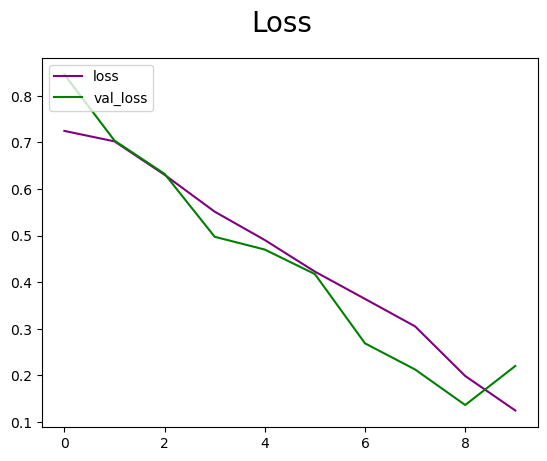

In [19]:
# Grafik loss
fig = plt.figure()
plt.plot(tmodel.history['loss'], color='purple', label='loss')
plt.plot(tmodel.history['val_loss'], color='green', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

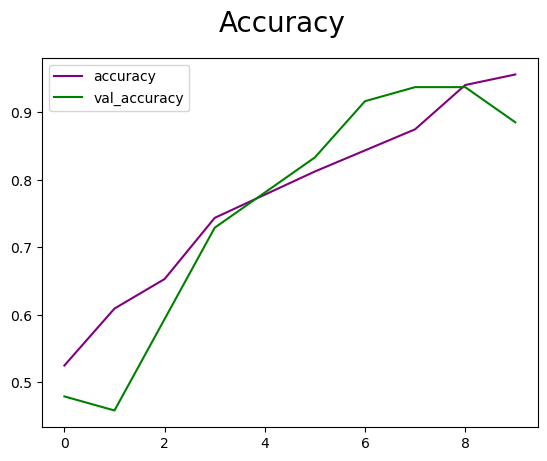

In [20]:
# Grafik akurasi
fig = plt.figure()
plt.plot(tmodel.history['accuracy'], color='purple', label='accuracy')
plt.plot(tmodel.history['val_accuracy'], color='green', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [21]:
import pandas as pd
from keras.metrics import Precision, Recall, BinaryAccuracy

pre = Precision()
re = Recall()
acc = BinaryAccuracy()

# Use the test batch we had set aside.
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

# Print and reset the states
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')


1/1 [==============================] - 0s 429ms/step
Precision: 0.8571428656578064, Recall: 1.0, Accuracy: 0.9375


# Testing

In [22]:
# Testing keseluruhan dalam satu batch 
y = y.reshape((-1,))
yhat = yhat.reshape((-1,))
yhat = yhat.round()
dfNew = pd.DataFrame(data={"Actual Value": y, "Predicted Value": yhat})

pd.set_option('display.max_rows', None)
dfNew

,Actual Value,Predicted Value
0,1,1.0
1,0,0.0
2,0,0.0
3,0,0.0
4,0,0.0
5,0,1.0
6,0,0.0
7,0,0.0
8,0,0.0
9,1,1.0


In [23]:
#Evaluasi model dengan melihat nilai precision, recall, dan f1-score
from sklearn.metrics import classification_report, confusion_matrix 
report = classification_report(y, yhat, target_names=['normal', 'benign'], digits=4)
print(report)

              precision    recall  f1-score   support

      normal     1.0000    0.9000    0.9474        20
      benign     0.8571    1.0000    0.9231        12

    accuracy                         0.9375        32
   macro avg     0.9286    0.9500    0.9352        32
weighted avg     0.9464    0.9375    0.9383        32



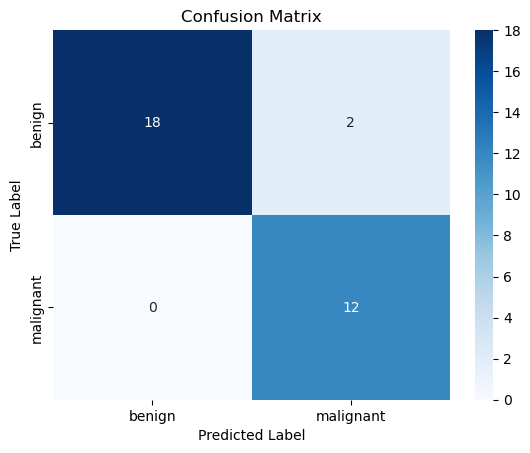

In [24]:
import seaborn as sns
# Confusion matrix 
cm = confusion_matrix(y, np.round(yhat))
class_names = ['benign', 'malignant']

# Plot heatmap dari confusion matrix
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()



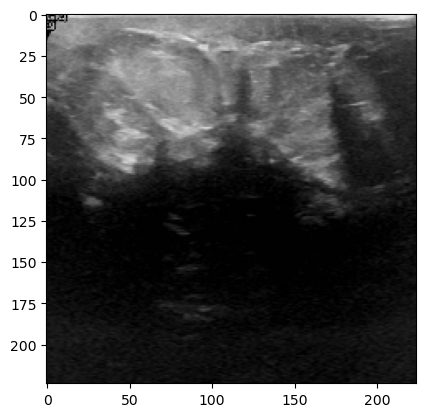

In [48]:
#Mengambil satu gambar di kelas malignant
img = cv2.imread('data/malignant/malignant (43).png')
resize = tf.image.resize(img, (224,224))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [49]:
# Image Score dalam rentang 0 sampai 1
Img_pred = model.predict(np.expand_dims(resize/255, 0))
# Mengambil nilai score dari gambar.
Img_pred.item()

1/1 [==============================] - 0s 48ms/step


0.9964921474456787

In [51]:
# Fungsi untuk testing satu gambar
def classifyImage(Img_pred):
  if Img_pred > 0.5: 
      print('MALIGNANT terdeteksi. ')
  else:
      print('BENIGN terdeteksi.')

In [52]:
classifyImage(Img_pred)

MALIGNANT terdeteksi. 


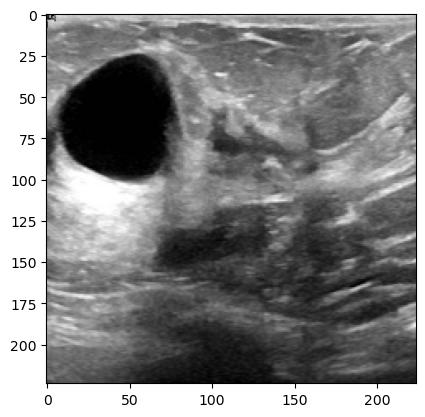

In [53]:
img = cv2.imread('data/benign/benign (10).png')
resize = tf.image.resize(img, (224,224))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [54]:
Img_pred = model.predict(np.expand_dims(resize/255, 0))
Img_pred.item()

1/1 [==============================] - 0s 55ms/step


0.16426019370555878

In [55]:
classifyImage(Img_pred)

BENIGN terdeteksi.
